## MD Unemployment Insurance Data Analysis

### Pt. 1: Intro:

Background: In this analysis, we will look at trends relating to new claims, payments disbursed, and first time vs. final checks issued

Dataset: The [Unemployment Insurance Data - July 2008 to April 2013](https://opendata.maryland.gov/Business-and-Economy/Unemployment-Insurance-Data-July-2008-to-April-201/3x6e-7i3k/about_data) comes from the Maryland Open Data Portal and includes monthly metrics on unemployment insurance from the Department of Labor, Licensing and Regulation over a 53-month span.

##### Glossary:
* UCFE: "Unemployment Compensation for Federal Employees"
* UCX: "Unemployment Compensation for Ex-Servicemembers"
* EUC: "Emergency Unemployment Compensation," which is a federally funded program that provides additional unemployment benefits to individuals who have exhausted their regular state unemployment benefits."
* UI: "Unemployment Insurance"


### Pt. 2: Import & clean data

In [3]:
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import calendar
import warnings
warnings.filterwarnings('ignore')

# Set plot format params
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300

In [4]:
# Read in csv
df = pd.read_csv('/Users/mattroth/Downloads/md_ds_roth.csv', parse_dates=['first_of_month'])
df.dropna(inplace=True)
df.head()

,month_pre_cleaned,first_of_month,month,total_new_claims_filed,UI_new_claims_filed,UCFE_new_claims_filed,UCX_new_claims_filed,EUC_total_claims_filed,EUC_million_dollars_paid_in_benefits,UI_persons_currently_drawing_benefits,...,EX_FED_EMPLOYEES_UI_#_first_ui_checks_issued,EX_MILITARY_UI_#_first_ui_checks_issued,percent_claims_filed_via_internet,final_payments,percent_first_UI_checks_issued_within_21d__reg_UI_DLA_87%,percent_first_UI_checks_issued_within_21d__ex_fed_DLA_70%,percent_first_UI_checks_issued_within_21d__ex_military_DLA_87%,n_determinations__nonmonetary_eg_quit_or_fired,percent_determinations_issued_within_21d_of_issue_detection__DLA_80%,n_open_employer_accounts
0,8-Jul,2008-07-01,Jul-08,23438.0,23137.0,172.0,129.0,12160.0,8.0,47462.0,...,52.0,66.0,0.19,4183.0,0.93,0.94,0.95,31599.0,0.82,144157.0
1,8-Aug,2008-08-01,Aug-08,20802.0,20557.0,142.0,103.0,5786.0,18.2,45475.0,...,33.0,55.0,0.20,3608.0,0.92,0.73,0.98,28867.0,0.86,141721.0
2,8-Sep,2008-09-01,Sep-08,22885.0,22640.0,116.0,129.0,3561.0,22.7,51922.0,...,39.0,68.0,0.20,4253.0,0.92,0.87,0.97,27793.0,0.82,141537.0
3,8-Oct,2008-10-01,Oct-08,29370.0,29079.0,166.0,125.0,4062.0,16.3,52133.0,...,50.0,76.0,0.39,4202.0,0.93,0.79,0.95,31933.0,0.84,141598.0
4,8-Nov,2008-11-01,Nov-08,30301.0,30046.0,152.0,103.0,2887.0,11.1,54787.0,...,29.0,69.0,0.49,3887.0,0.92,0.95,0.97,32091.0,0.83,141981.0


In [5]:
# Extract month and year to new columns
df['month'] = df['first_of_month'].dt.month
df['year'] = df['first_of_month'].dt.year

### Pt. 3: EDA & Visualizations

#### Pt. 3a: New Claims by Month & Year

In [6]:
# Group by year and sum
by_year = df.groupby('year')['total_new_claims_filed'].sum().reset_index()
by_year

,year,total_new_claims_filed
0,2008,170044.0
1,2009,420612.0
2,2010,381701.0
3,2011,351262.0
4,2012,326509.0
5,2013,103034.0


In [7]:
# Group by month and avg
by_month = df.groupby('month')['total_new_claims_filed'].mean().reset_index()
by_month

,month,total_new_claims_filed
0,1,37741.8
1,2,28235.0
2,3,28299.6
3,4,28327.6
4,5,27546.5
5,6,32411.0
6,7,29008.8
7,8,26940.8
8,9,25094.6
9,10,29665.8


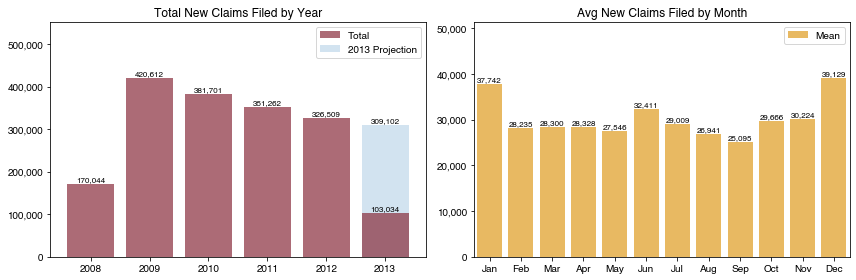

In [8]:
# Plot total claims by year
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
sns.barplot(
    data=by_year,
    x='year',
    y='total_new_claims_filed',
    color='#981e32',
    alpha=0.7,
    label='Total',
    zorder=1,
    ax=axs[0]
)

# Create projection for 2013 to fill in from partial data
d_2013 = by_year.iloc[5]['total_new_claims_filed']
by_month[0:4]['total_new_claims_filed'].sum() / by_month['total_new_claims_filed'].sum()
axs[0].bar(
    5,
    (d_2013 * 3) , 
    alpha=0.2, 
    label='2013 Projection',
    zorder=0
)

# Plot avg claims by month
sns.barplot(
    data=by_month,
    x='month',
    y='total_new_claims_filed',
    color='#FFA500',
    label='Mean',
    alpha=0.7,
    ax=axs[1]
)

axs[0].set_title('Total New Claims Filed by Year')
axs[1].set_title('Avg New Claims Filed by Month')

for a in axs:    
    a.set_ylim((0, 1.25 * a.get_ylim()[1]))    
    a.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    a.set_xlabel(None)
    a.set_ylabel(None)
    a.legend()

# Adding data labels
for bar in axs[0].patches:  
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', 
                ha='center', va='bottom', fontsize=8)

for bar in axs[1].patches:  
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', 
                ha='center', va='bottom', fontsize=8)    

axs[1].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
plt.tight_layout()
plt.show()

#### Pt. 3b: Amount Paid by Month & Year

In [9]:
# Group by year and sum
by_year = df.groupby('year')['million_dollars_paid_in_benefits'].sum().reset_index()
by_year

,year,million_dollars_paid_in_benefits
0,2008,340.5
1,2009,1069.7
2,2010,900.6
3,2011,795.7
4,2012,778.5
5,2013,263.2


In [10]:
# Group by month and avg
by_month = df.groupby('month')['million_dollars_paid_in_benefits'].mean().reset_index()
by_month

,month,million_dollars_paid_in_benefits
0,1,83.00
1,2,77.82
2,3,84.24
3,4,73.02
4,5,70.25
5,6,74.60
6,7,66.42
7,8,71.28
8,9,59.78
9,10,61.32


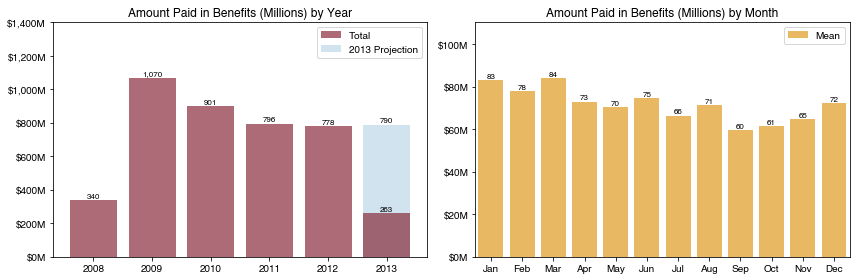

In [11]:
# Plot total claims by year
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
sns.barplot(
    data=by_year,
    x='year',
    y='million_dollars_paid_in_benefits',
    color='#981e32',
    alpha=0.7,
    label='Total',
    zorder=1,
    ax=axs[0]
)

# Create projection for 2013 to fill in from partial data
d_2013 = by_year.iloc[5]['million_dollars_paid_in_benefits']
by_month[0:4]['million_dollars_paid_in_benefits'].sum() / by_month['million_dollars_paid_in_benefits'].sum()
axs[0].bar(
    5,
    (d_2013 * 3) , 
    alpha=0.2, 
    label='2013 Projection',
    zorder=0
)

# Plot avg claims by month
sns.barplot(
    data=by_month,
    x='month',
    y='million_dollars_paid_in_benefits',
    color='#FFA500',
    label='Mean',
    alpha=0.7,
    ax=axs[1]
)

axs[0].set_title('Amount Paid in Benefits (Millions) by Year')
axs[1].set_title('Amount Paid in Benefits (Millions) by Month')

for a in axs:    
    a.set_ylim((0, 1.25 * a.get_ylim()[1]))    
    a.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}M'))
    a.set_xlabel(None)
    a.set_ylabel(None)
    a.legend()

# Adding data labels
for bar in axs[0].patches:  
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', 
                ha='center', va='bottom', fontsize=8)

for bar in axs[1].patches:  
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', 
                ha='center', va='bottom', fontsize=8)    

axs[1].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
plt.tight_layout()
plt.show()

#### Pt. 3c: Plot variables by month

In [12]:
# Custom plotting function to plot variable by month
def plot_var_by_month(yvar, ax, legend=None, ylab=None, c=None):
    
    # Create lineplot
    sns.lineplot(
        data=df,
        x='first_of_month',
        y=yvar,
        label=legend,
        ax=ax,
        color=c
    )
    
    # No xlabel
    ax.set_xlabel(None)
    
    # Set up xticks for every 3rd month
    ax.set_xticks(df['first_of_month'][::3])
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b '%y"))        
    ax.set_xticklabels(df['first_of_month'][::3].dt.strftime("%b '%y"), rotation=60, ha='right')        

    # Create grid
    ax.set_xticks(df['first_of_month'], minor=True)  # Set minor ticks for every month
    ax.grid(axis='x', which='minor', alpha=0.15)
    ax.grid(axis='x', which='major', alpha=0.4)
    ax.grid(axis='y', which='major', alpha=0.4)

    # Add vertical lines at specific dates
    fom = df['first_of_month']
    for date in [fom[6], df['first_of_month'][18], fom[30], fom[42], fom[54]]:
        ax.axvline(x=date, color='gray', linestyle='--', linewidth=1, alpha=0.45)

    # Include ylabel if arg is set
    if ylab != None:
        ax.set_ylabel(ylab)
        ax.legend(loc='upper left')
    
        

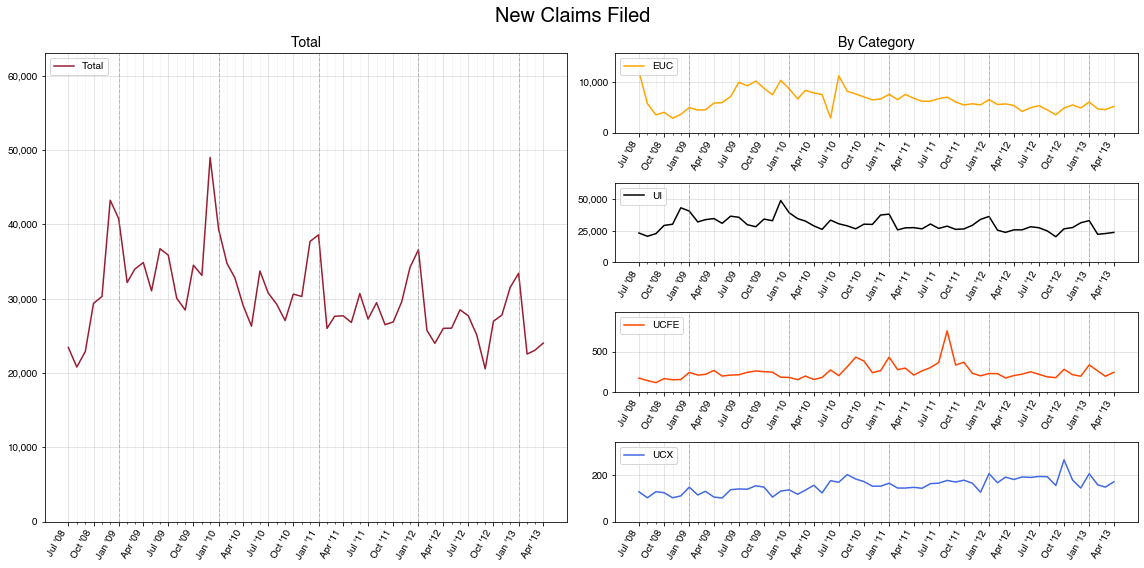

In [13]:
# Plot new claims by month
plt.figure(figsize=(16, 8))

# Left column (big plot for total)
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('Total', fontsize=14)

# Right column (4 small plots for each category)
ax2 = plt.subplot(4, 2, 2)
ax2.set_title('By Category', fontsize=14)
ax3 = plt.subplot(4, 2, 4)
ax4 = plt.subplot(4, 2, 6)
ax5 = plt.subplot(4, 2, 8)

# Combine
axes = [ax1, ax2, ax3, ax4, ax5]

# Plot in each subplot
plot_var_by_month('total_new_claims_filed', ax=ax1, legend='Total', ylab='', c="#981e32")
plot_var_by_month('EUC_total_claims_filed', ax=ax2, legend='EUC', ylab='', c='#FFA500')
plot_var_by_month('UI_new_claims_filed', ax=ax3, legend='UI', ylab='', c='black')
plot_var_by_month('UCFE_new_claims_filed', ax=ax4, legend='UCFE', ylab='', c='#FF4500')
plot_var_by_month('UCX_new_claims_filed', ax=ax5, legend='UCX', ylab='', c='#4169E1')

# Format axes
for a in axes:    
    a.set_ylim((0, 1.25 * a.get_ylim()[1]))    
    a.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Format plot
plt.suptitle('New Claims Filed', fontsize=20)
plt.tight_layout()
plt.show()


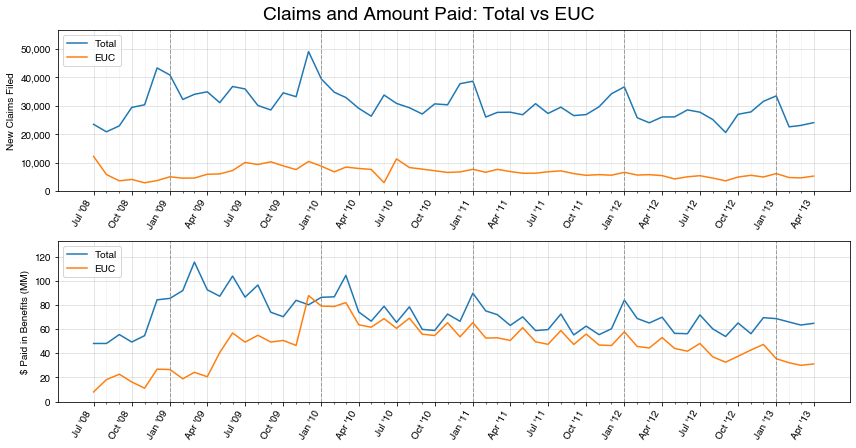

In [14]:
# Plot new claims and amount paid by month
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False)
plot_var_by_month('total_new_claims_filed', ax=axs[0], legend='Total', ylab="New Claims Filed")
plot_var_by_month('EUC_total_claims_filed', ax=axs[0],  legend='EUC', ylab="New Claims Filed")
plot_var_by_month('million_dollars_paid_in_benefits', ax=axs[1],  legend='Total', ylab="$ Paid in Benefits (MM)")
plot_var_by_month('EUC_million_dollars_paid_in_benefits', ax=axs[1],  legend='EUC', ylab="$ Paid in Benefits (MM)")

# Format Axes
for a in axs:    
    a.set_ylim((0, 1.1 * a.get_ylim()[1]))
    a.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Format plot
plt.tight_layout()
plt.suptitle('Claims and Amount Paid: Total vs EUC', y=1.03, fontsize=19)
plt.show()

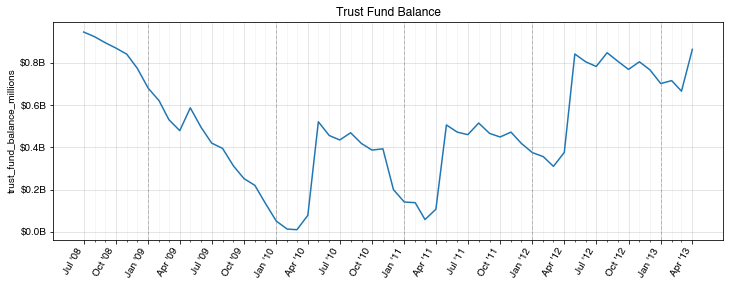

In [15]:
# Plot Trust fund balance by month
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month('trust_fund_balance_millions', ax=ax)

# Format axes and plot
formatter = FuncFormatter(lambda x, pos: f'${x/1000:.1f}B')
ax.yaxis.set_major_formatter(formatter)
plt.title('Trust Fund Balance')
plt.show()

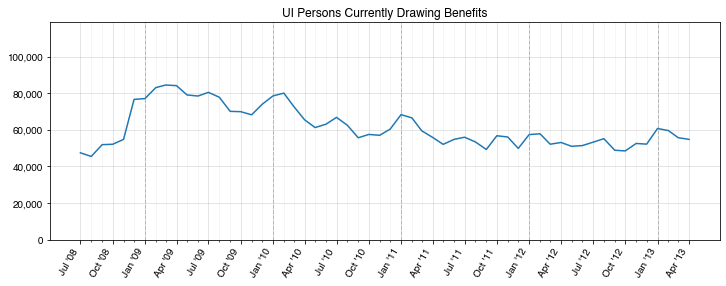

In [16]:
# Plot persons drawing benefits balance by month
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month('UI_persons_currently_drawing_benefits', ax)
ax.set_ylim((0, 1.25 * ax.get_ylim()[1]))

# Format axis
ax.set_ylim((0, 1.1 * ax.get_ylim()[1]))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Format plot
plt.title('UI Persons Currently Drawing Benefits')
plt.ylabel(None)
plt.show()

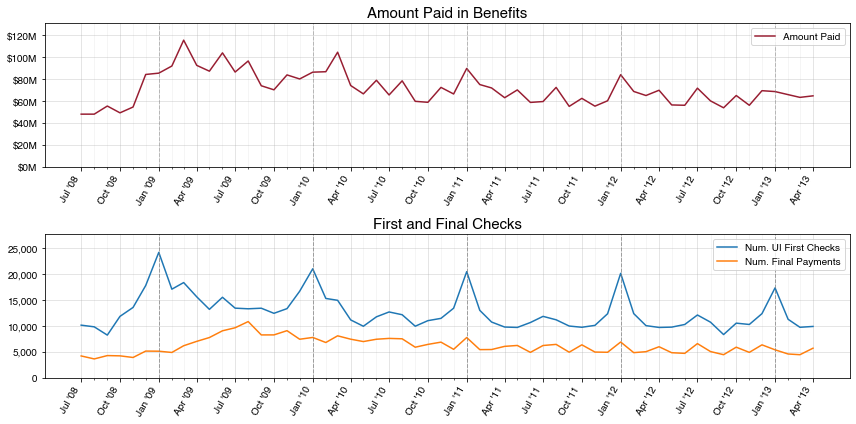

In [17]:
# Plot amount paid and first & last checks by month
fig, axs = plt.subplots(nrows=2, figsize=(12,6))
plot_var_by_month('million_dollars_paid_in_benefits', ax=axs[0], legend='Amount Paid', c='#981e32')
plot_var_by_month('REGULAR_UI_#_first_ui_checks_issued', ax=axs[1], legend='Num. UI First Checks')
plot_var_by_month('final_payments', ax=axs[1], legend='Num. Final Payments')

# Format axes
for a in axs:    
    a.set_ylim((0, 1.1 * a.get_ylim()[1]))
    a.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    a.set_ylabel(None)
    a.legend(loc='upper right')

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}M'))
axs[0].set_title('Amount Paid in Benefits', fontsize=15)
axs[1].set_title('First and Final Checks', fontsize=15)

# Format plot
plt.ylabel(None)
plt.tight_layout()
plt.show()

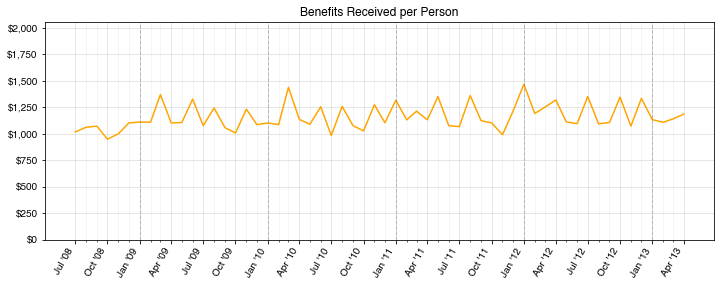

In [18]:
# Create amount per person column
df['dollars_per_recipient'] = df['million_dollars_paid_in_benefits'] * 1000000 / df['UI_persons_currently_drawing_benefits']

# Plot benefits per person by month
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month('dollars_per_recipient', ax, c='#FFA500')
ax.set_ylim((0, 1.25 * ax.get_ylim()[1]))

# Format axis
ax.set_ylim((0, 1.1 * ax.get_ylim()[1]))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Format plot
plt.title('Benefits Received per Person')
plt.ylabel(None)
plt.show()

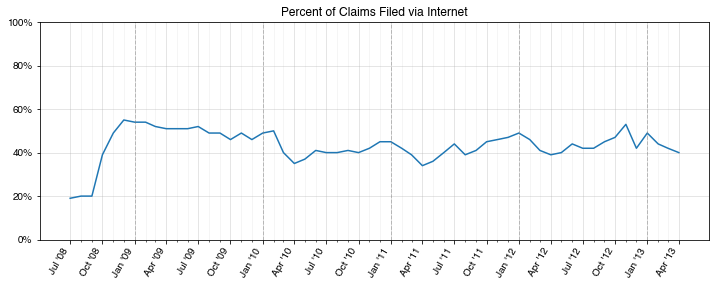

In [19]:
# Plot percent via internet by month
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month(' percent_claims_filed_via_internet ', ax=ax)

# Format axis
plt.ylim((0,1))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Format plot
plt.title('Percent of Claims Filed via Internet')
plt.ylabel(None)
plt.show()

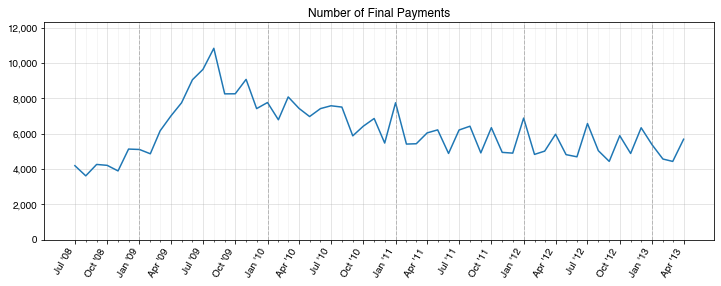

In [20]:
# Plot n final payments by month
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month('final_payments', ax=ax)

# Format axes
ax.set_ylim((0, 1.1 * ax.get_ylim()[1]))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Format plot
plt.title('Number of Final Payments')
plt.ylabel(None)
plt.show()

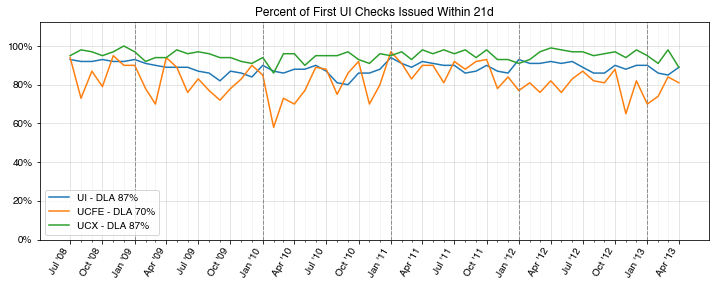

In [21]:
# Plot percent first ui checks within 21d
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month(' percent_first_UI_checks_issued_within_21d__reg_UI_DLA_87% ', ax=ax, legend='UI - DLA 87%')
plot_var_by_month(' percent_first_UI_checks_issued_within_21d__ex_fed_DLA_70% ', ax=ax, legend='UCFE - DLA 70%')
plot_var_by_month(' percent_first_UI_checks_issued_within_21d__ex_military_DLA_87% ', ax=ax, legend='UCX - DLA 87%')

# Format axes
ax.set_ylim((0, 1.1 * ax.get_ylim()[1]))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Format plot
plt.title('Percent of First UI Checks Issued Within 21d')
plt.ylabel(None)
plt.show()

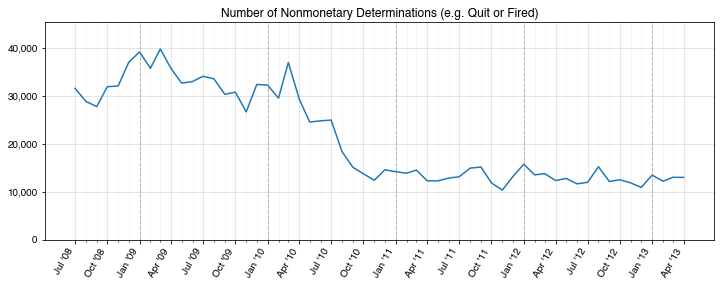

In [22]:
# Plot nonmonetoary determinations by month
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month('n_determinations__nonmonetary_eg_quit_or_fired', ax=ax)

# Format axes
ax.set_ylim((0, 1.1 * ax.get_ylim()[1]))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Format plot
plt.title('Number of Nonmonetary Determinations (e.g. Quit or Fired)')
plt.ylabel(None)
plt.show()

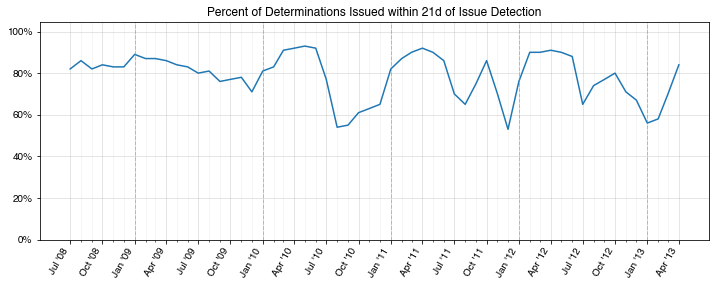

In [23]:
# Plot percent of determinations iss within 21d by month
fig, ax = plt.subplots(figsize=(12,4))
plot_var_by_month(' percent_determinations_issued_within_21d_of_issue_detection__DLA_80% ', ax=ax)

# Format axes
ax.set_ylim((0, 1.1 * ax.get_ylim()[1]))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Format plot
plt.title('Percent of Determinations Issued within 21d of Issue Detection')
plt.ylabel(None)
plt.show()

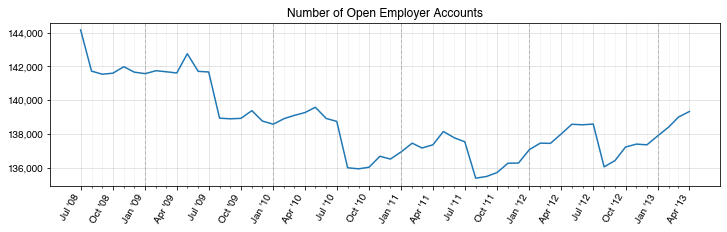

In [24]:
# Plot number of open employer accounts by month
fig, ax = plt.subplots(figsize=(12,3))
plot_var_by_month('n_open_employer_accounts', ax=ax)

# Format axes
# ax.set_ylim((0, 1.1 * ax.get_ylim()[1]))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Format plot
plt.title('Number of Open Employer Accounts')
plt.ylabel(None)
plt.show()


### Pt. 4: Forecasting

#### Pt. 4a: Prep data and write helper functions

In [25]:
# Set df index to month
df_forecast = df.set_index(['first_of_month']).loc['2008-12-01':]

# Set exogenous variables to improve predictions
exog_vars = [ 'EUC_total_claims_filed',
    'EUC_million_dollars_paid_in_benefits',
    'UI_persons_currently_drawing_benefits',
    'million_dollars_paid_in_benefits',
    'REGULAR_UI_#_first_ui_checks_issued',
    'final_payments',
    'n_determinations__nonmonetary_eg_quit_or_fired',
    'n_open_employer_accounts',
]


In [26]:

# Function to examine and plot seasonal trends and residuals of Y var
def seasonal_decomp(Y_var):
    
    # Perform seasonal decomp
    result = seasonal_decompose(df_forecast[Y_var].dropna(), model='add', period=12)
    trend = result.trend.dropna()
    seasonal = result.seasonal.dropna()
    residual = result.resid.dropna()

    # Plot decomposed components
    fig, axs = plt.subplots(nrows=4, figsize=(12,5))
    axs[0].plot(df_forecast[Y_var], label='Original Series')
    axs[1].plot(trend, label='Trend')
    axs[2].plot(seasonal, label='Seasonal')
    axs[3].plot(residual, label='Residuals')

    # Set up legend
    for a in axs:
        a.legend(loc='upper right')
    
    # Add title
    title_case = Y_var.replace('_', ' ').title()
    plt.suptitle(f'Seasonal Decomposition: {title_case}', y=0.99, fontsize=16)
        
    plt.tight_layout()
    plt.show()

In [27]:
# Function to fit SARMIAX model to data 
def fit_SARIMAX(Y_var):
    
    # Fit model
    model = pm.auto_arima(
                df_forecast[Y_var], 
                exogenous=df_forecast[[v for v in exog_vars if v != Y_var]],
                start_p=1, start_q=1,
                test='adf',
                max_p=3, max_q=3, m=12,
                start_P=0, seasonal=True,
                d=None, D=1,
                trace=False,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True
            )

    # Return fitted model
    return model

In [28]:
# Function to plot forecast after fitting SARIMAX
def plot_forecast(model, Y_var, periods=24):
    
    # Forecast    
    fitted, ci = model.predict(n_periods=periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_forecast.index[-1] + pd.DateOffset(months=1), periods = periods, freq='MS')

    # make series for plotting purpose
    fitted = pd.Series(fitted, index=index_of_fc)
    lower = pd.Series(ci[:, 0], index=index_of_fc)
    upper = pd.Series(ci[:, 1], index=index_of_fc)

    # Set up plot
    fig, ax = plt.subplots(figsize=(12,4))

    # Plot actual
    plt.plot(df_forecast[Y_var], color='#981e32', label='Actual')

    # Plot forecast
    plt.plot(fitted, color='#FFA500', label='Forecast')

    # Plot confidence interval
    plt.fill_between(
        lower.index, 
        lower, 
        upper, 
        color='#FFA500', 
        alpha=.15,
        label='95% CI'
    )

    # Plot connecting line
    plt.plot(
        pd.concat([df_forecast[Y_var].iloc[-1:], fitted.iloc[:1]]), 
        color='#FFA500', 
        linestyle='dotted',
        linewidth=1.25,
    )

    # Format plot
    plt.grid(alpha=0.2)
    title_case = Y_var.replace('_', ' ').title()
    plt.title(f'{periods} Month Forecast: {title_case}')
    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.legend()
    plt.show()

#### Pt. 4b: Forecasting Total New Claims Filed

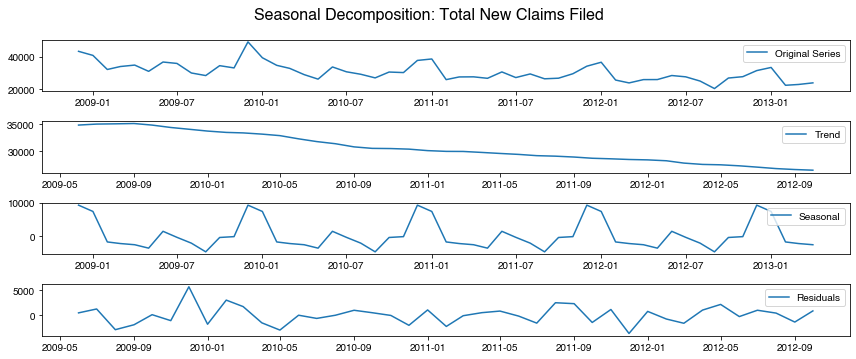

In [29]:
# Plot seasonal decomposition
seasonal_decomp('total_new_claims_filed')

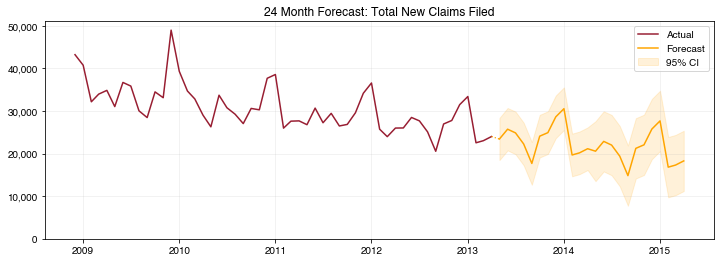

In [30]:
# Fit model and show forecast from fitted model
model = fit_SARIMAX('total_new_claims_filed')
plot_forecast(model=model, Y_var='total_new_claims_filed', periods=24)

#### Pt. 4c: Forecasting UI Persons Drawing Benefits

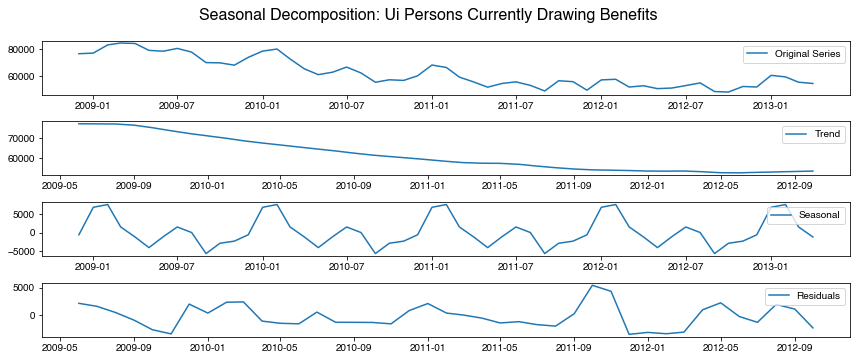

In [31]:
seasonal_decomp('UI_persons_currently_drawing_benefits')

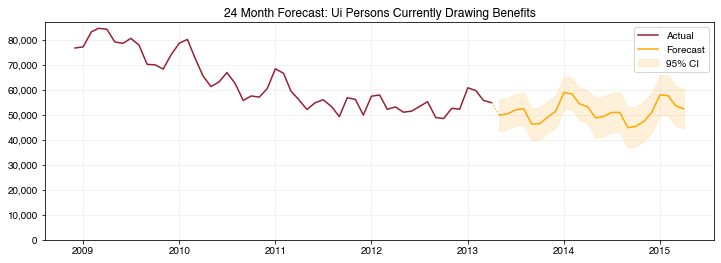

In [32]:
# Fit model and show forecast from fitted model
model = fit_SARIMAX('UI_persons_currently_drawing_benefits')
plot_forecast(model=model, Y_var='UI_persons_currently_drawing_benefits', periods=24)

#### Pt. 4d: Forecasting Dollars Paid in Benefits 

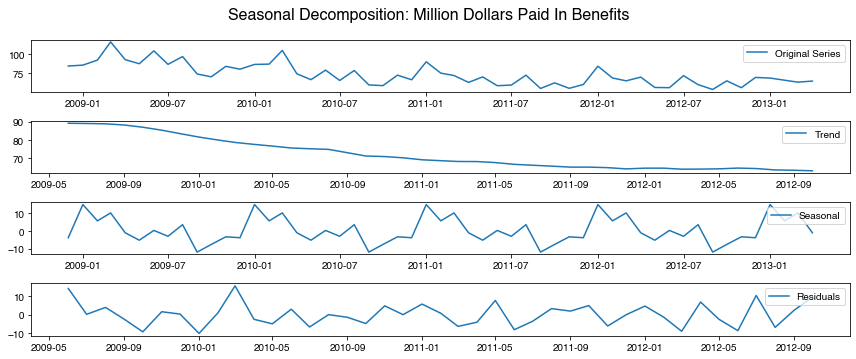

In [33]:
seasonal_decomp('million_dollars_paid_in_benefits')

In [ ]:
# Fit model and show forecast from fitted model
model = fit_SARIMAX('million_dollars_paid_in_benefits')
plot_forecast(model=model, Y_var='million_dollars_paid_in_benefits', periods=24)

#### Pt. 4e: Forecasting First UI Checks ISsued

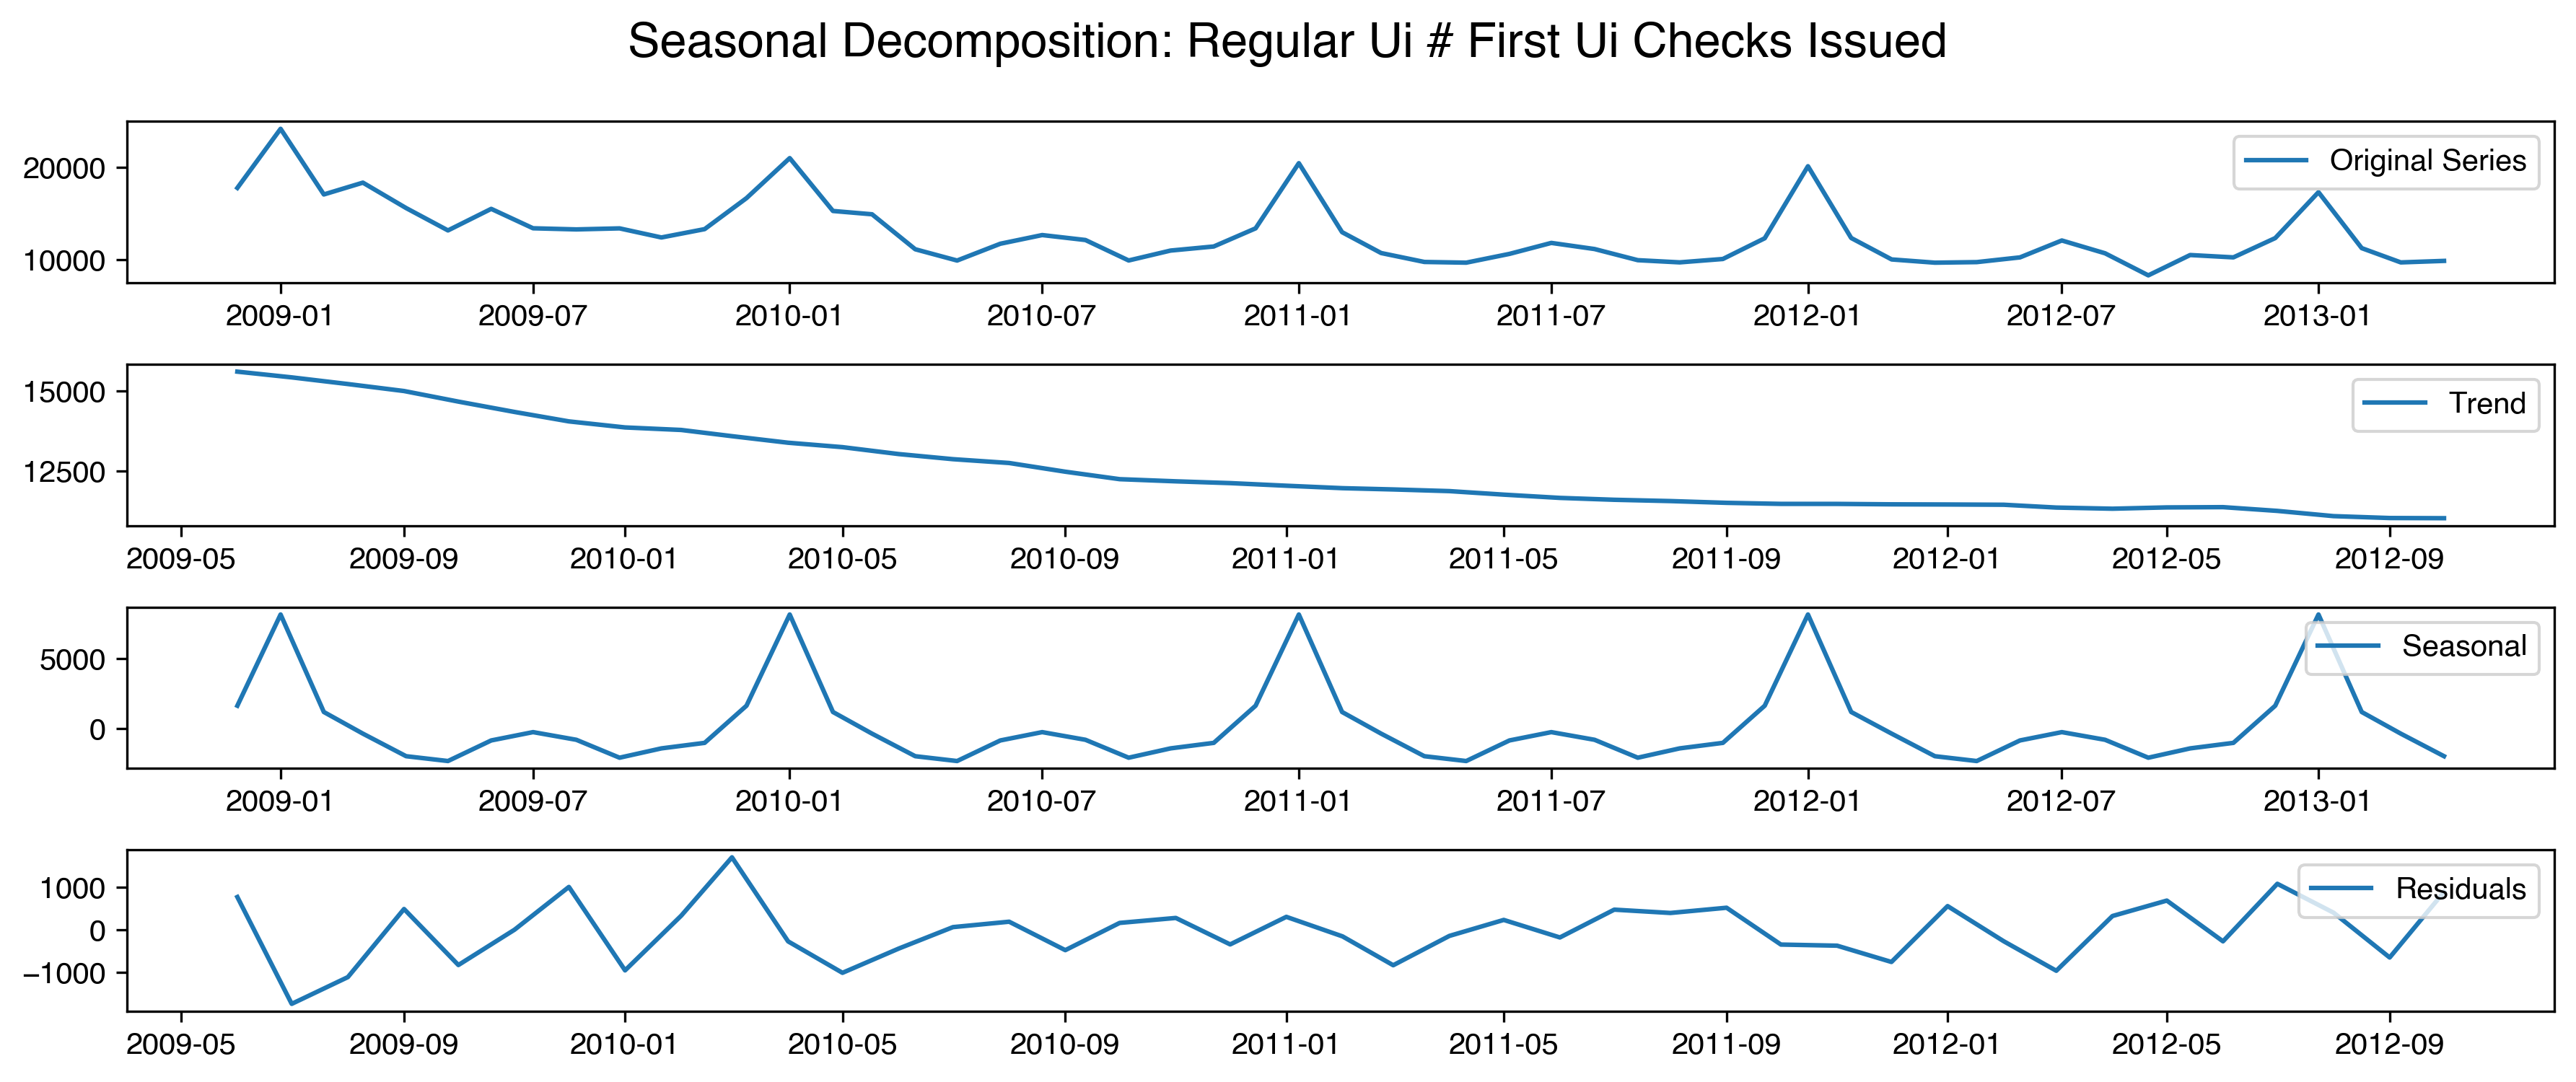

In [61]:
seasonal_decomp('REGULAR_UI_#_first_ui_checks_issued')

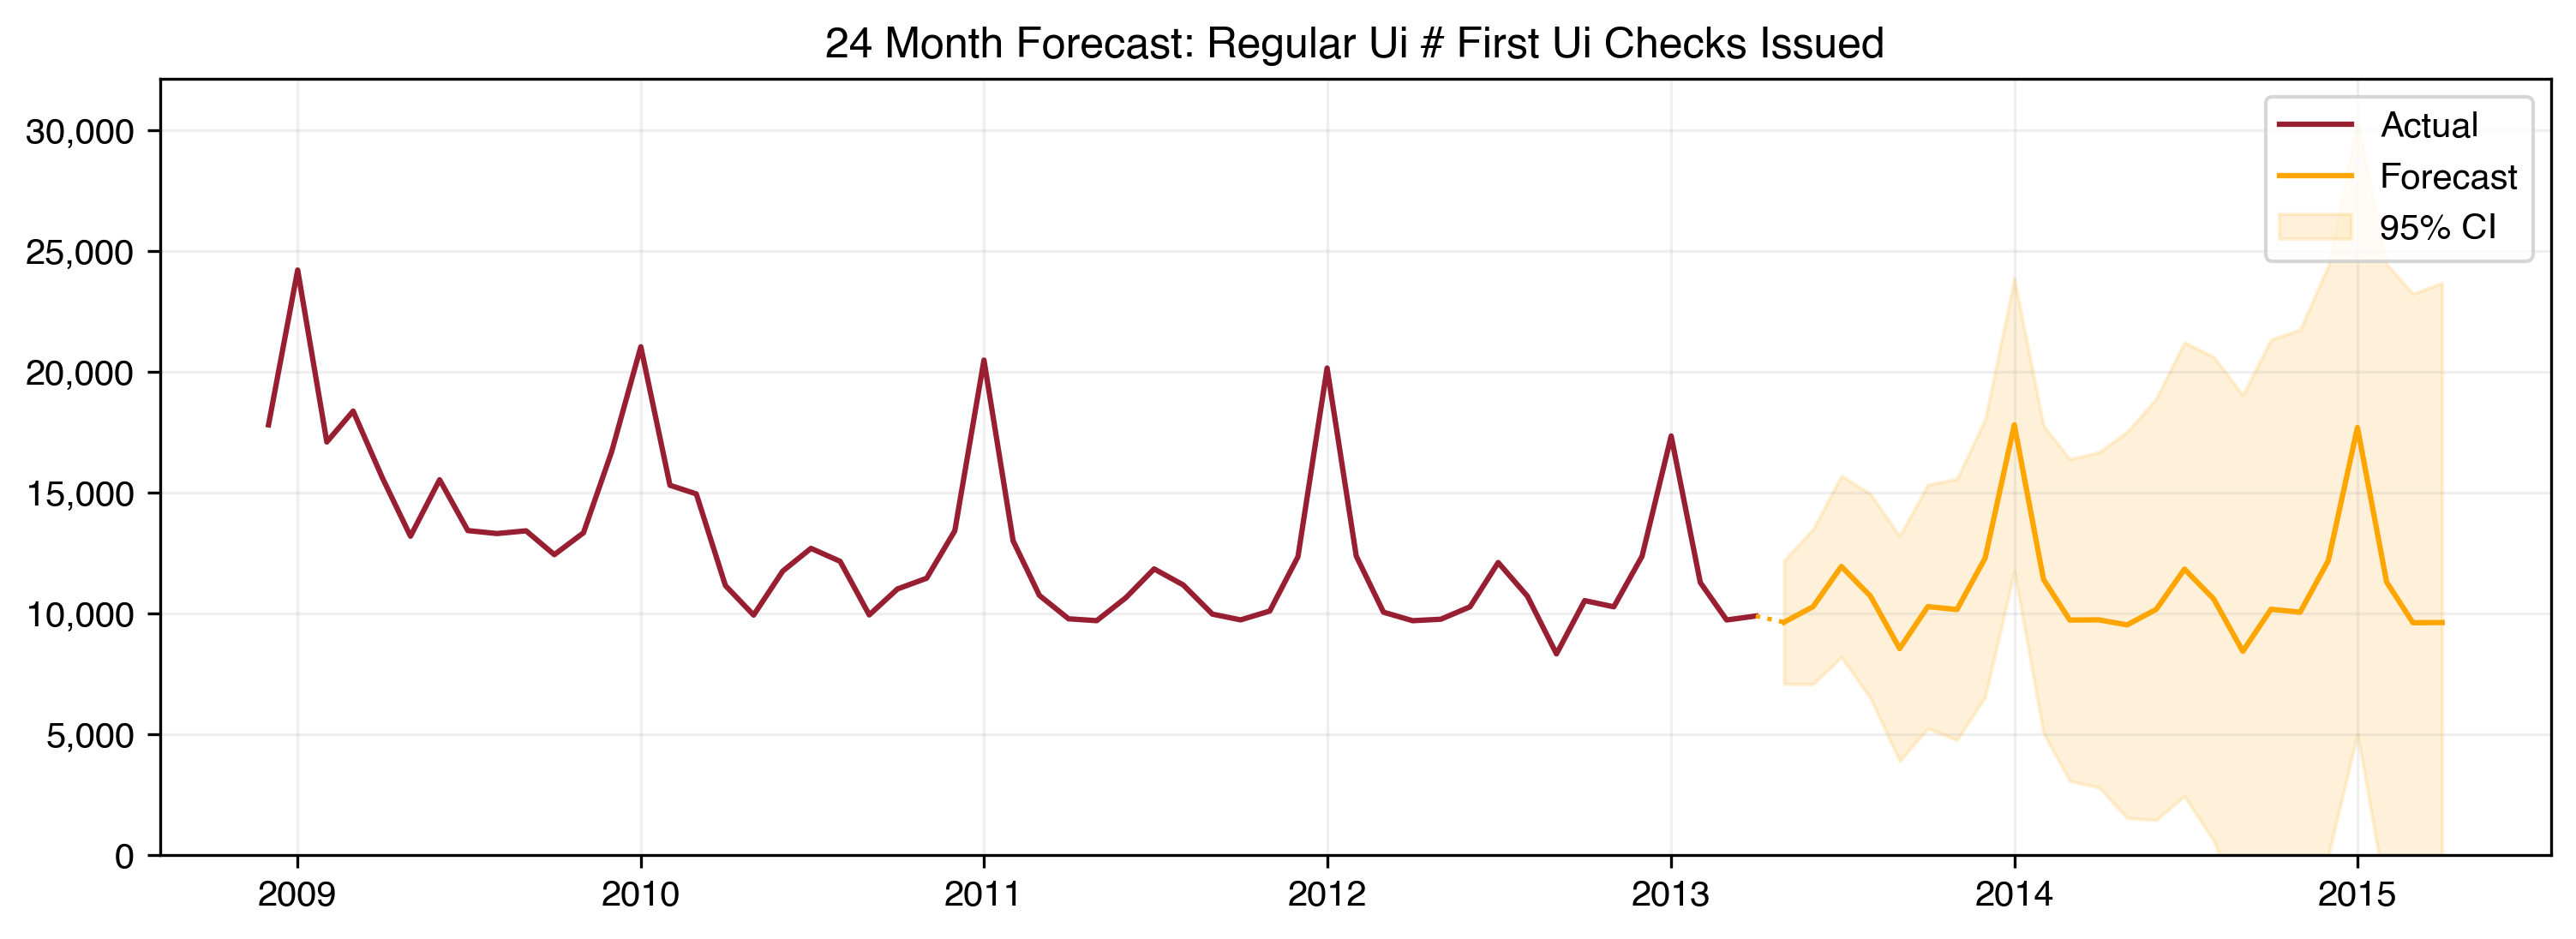

In [62]:
# Fit model and show forecast from fitted model
model = fit_SARIMAX('REGULAR_UI_#_first_ui_checks_issued')
plot_forecast(model=model, Y_var='REGULAR_UI_#_first_ui_checks_issued', periods=24)

#### Pt. 4f: Forecasting Final Payments

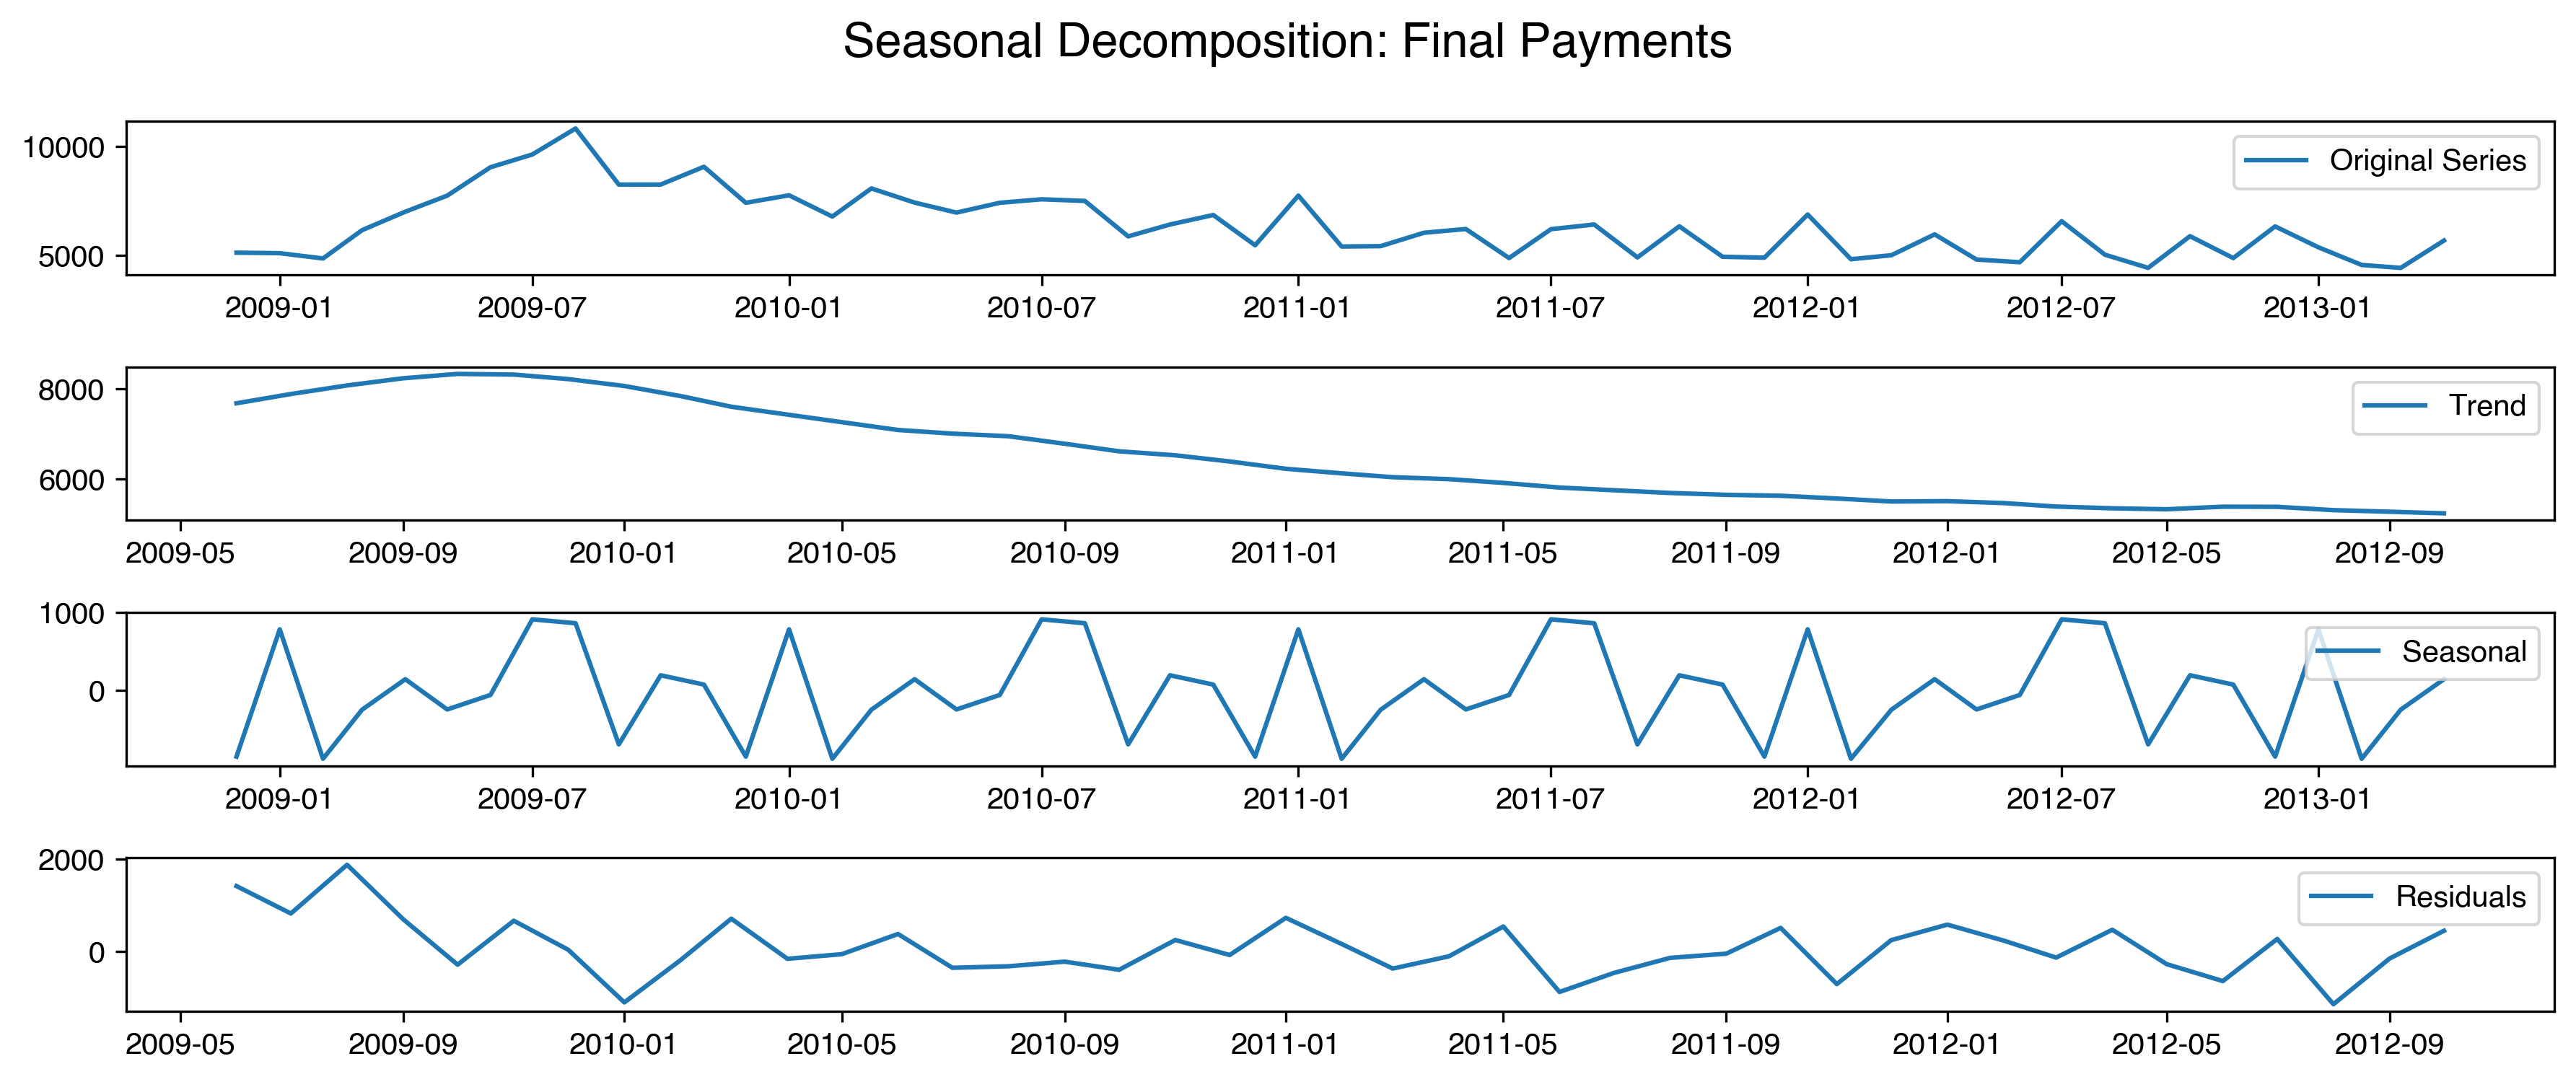

In [63]:
seasonal_decomp('final_payments')

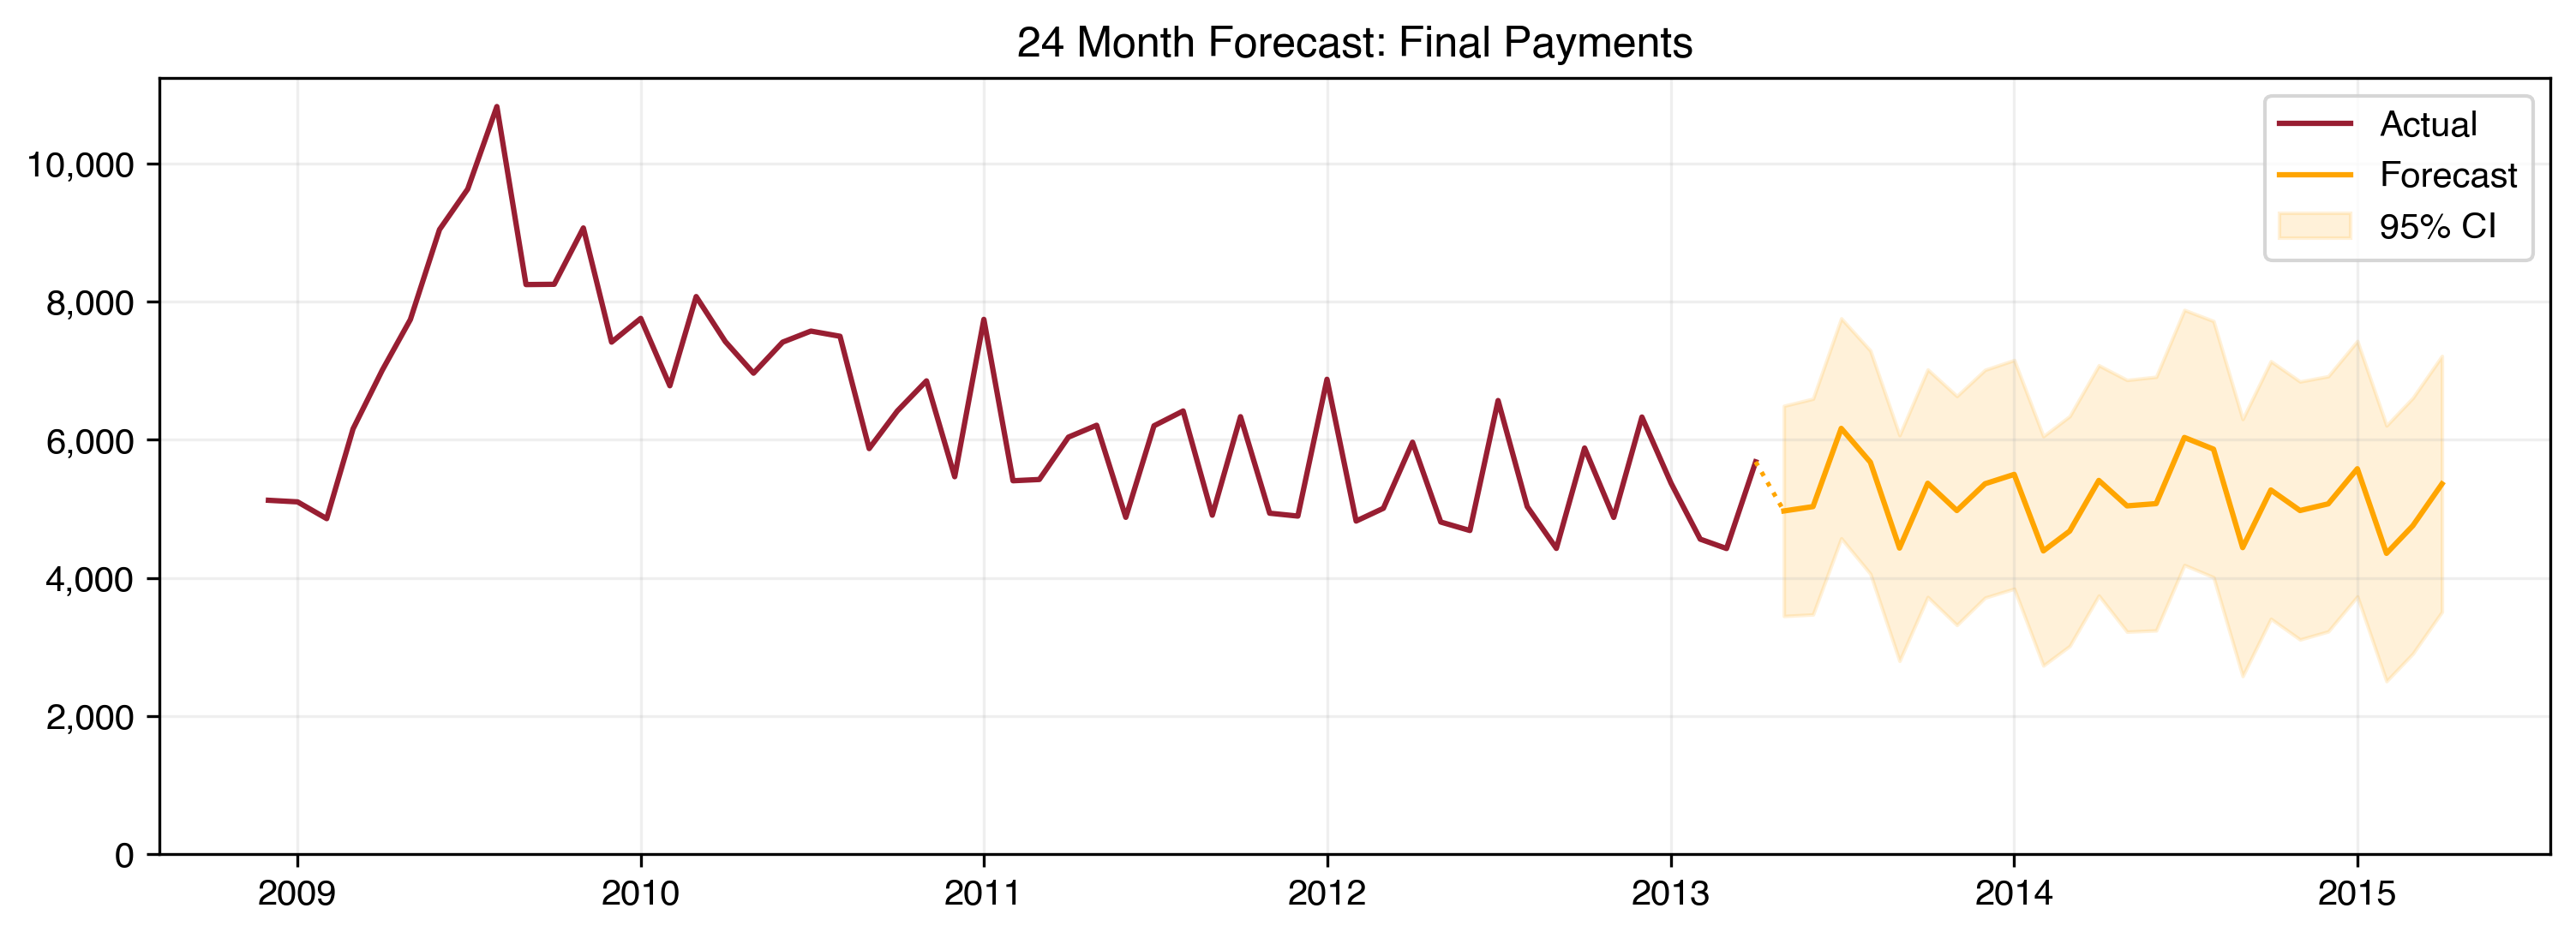

In [64]:
# Fit model and show forecast from fitted model
model = fit_SARIMAX('final_payments')
plot_forecast(model=model, Y_var='final_payments', periods=24)